# Descripción del Proyecto

Crear un modelo de Machinne Learning para Zyfra. La empresa crea soluciones eficientes para la industria pesada. El modelo debe ser capaz de predecir cuánto oro se puede recuperar del mineral de oro. El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.

## Instrucciones

1. Prepara los datos

    1. Abre los archivos y examina los datos.

        Ruta de acceso a los archivos:

        /datasets/gold_recovery_train.csv
        /datasets/gold_recovery_test.csv
        /datasets/gold_recovery_full.csv
    2. Comprueba que el cálculo de la recuperación sea correcto. Calcula la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento. Encuentra el EAM entre tus cálculos y los valores de la característica. Facilita los resultados.

    3. Analiza las características no disponibles en el conjunto de prueba. ¿Cuáles son estos parámetros? ¿Cuál es su tipo?

    4. Realiza el preprocesamiento de datos.

2. Analiza los datos

    1. Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

    2. Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

    3. Considera las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. ¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? Describe los resultados y elimina las anomalías.

3. Construye el modelo

    1. Escribe una función para calcular el valor final de sMAPE.

    2. Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba. Facilita los resultados.

# Cargar las librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import normaltest
import warnings
warnings.filterwarnings("ignore")

# EDA

### Open the files and look into the data.

In [2]:
gold_recovery_train = pd.read_csv('https://raw.githubusercontent.com/Davichobacter/data_science_tt/refs/heads/main/Sprint_13/data/gold_recovery_full.csv')
gold_recovery_test = pd.read_csv('https://raw.githubusercontent.com/Davichobacter/data_science_tt/refs/heads/main/Sprint_13/data/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('https://raw.githubusercontent.com/Davichobacter/data_science_tt/refs/heads/main/Sprint_13/data/gold_recovery_train.csv')

In [3]:
def explorar_dataset(df):
    """
    Explora un DataFrame mostrando información clave.

    Esta función imprime: información general del DataFrame (df.info()),
    sus dimensiones (df.shape), las primeras 15 filas (df.head(15)),
    estadísticas descriptivas (df.describe()), el conteo de valores nulos
    (df.isnull().sum()) y el conteo de filas duplicadas (df.duplicated().sum()).

    Parámetros:
        df (pd.DataFrame): El DataFrame a explorar.
    """

    print('---' * 10, '\n', f'Información del dataframe')
    print(df.info())
    print('---' * 10, '\n', f'Dimensiones del dataframe')
    print(df.shape)
    print('---' * 10, '\n', f'Valores nulos del dataframe')
    print(df.isnull().sum() / len(df) * 100)
    print('---' * 10, '\n', f'Valores duplicados del dataframe')
    print(df.duplicated().sum())
    print('---' * 10)

Let's check what we have in our datasets.

In [4]:
explorar_dataset(gold_recovery_train)

------------------------------ 
 Información del dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail

In [5]:
explorar_dataset(gold_recovery_test)

------------------------------ 
 Información del dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floa

In [6]:
explorar_dataset(gold_recovery_full)

------------------------------ 
 Información del dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail

In [7]:
def formato_fecha(dataframe, columna):
    """
    Convierte una columna de un DataFrame a formato de fecha.

    Parámetros:
        dataframe (pd.DataFrame): El DataFrame al que pertenece la columna.
        columna (str): El nombre de la columna a convertir.
    """
    fechas = pd.to_datetime(dataframe[columna])

    dataframe[columna] = fechas.dt.strftime('%Y-%m-%d %H')

    return dataframe

In [8]:
gold_recovery_train = formato_fecha(gold_recovery_train, 'date')
gold_recovery_test = formato_fecha(gold_recovery_test, 'date')
gold_recovery_full = formato_fecha(gold_recovery_full, 'date')

### Check that recovery is calculated correctly.

In [9]:
def recovery(C, F, T):
    """
    Calcula el porcentaje de recuperación metalúrgica.

    Esta función aplica la fórmula de recuperación:
        recovery = (C * (F - T)) / (F * (C - T)) * 100

    Posteriormente, se reemplazan por valores nulos (NaN) aquellos
    resultados que sean menores a 0 o mayores a 100, ya que se
    consideran físicamente no válidos.

    Parámetros:
        C (array-like o pd.Series): Concentración del concentrado.
        F (array-like o pd.Series): Concentración de la alimentación.
        T (array-like o pd.Series): Concentración de la cola.

    Retorna:
        recovery (array-like o pd.Series): Porcentaje de recuperación válido.
    """

    recovery = (C * (F - T)) / (F * (C - T)) * 100

    recovery[recovery < 0] = np.nan
    recovery[recovery > 100] = np.nan

    return recovery

In [10]:
#creating the column with calculations:
gold_recovery_train['rougher.output.calc'] = recovery(gold_recovery_train['rougher.output.concentrate_au'],
           gold_recovery_train['rougher.input.feed_au'], gold_recovery_train['rougher.output.tail_au'])

In [11]:
#comparing results:
gold_recovery_train[['rougher.output.recovery', 'rougher.output.calc']].head()

,rougher.output.recovery,rougher.output.calc
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [12]:
#filling NA with 0 for MAE calculations:
gold_recovery_train['rougher.output.recovery'].fillna(0, inplace=True)
gold_recovery_train['rougher.output.calc'].fillna(0, inplace=True)

In [13]:
mean_absolute_error(gold_recovery_train['rougher.output.recovery'], gold_recovery_train['rougher.output.calc'])

8.497257797509997e-15

The MAE value is low which means that means that recovery calculations is corect

### Analyze the features not available in the test set.

In [14]:
test_columns = gold_recovery_test.columns
df_non_test_columns = gold_recovery_full.drop(test_columns, axis=1)

In [15]:
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['date', 'rougher.output.recovery', 'final.output.recovery']],
                           how = 'left', on = 'date')

In [16]:
explorar_dataset(df_non_test_columns)

------------------------------ 
 Información del dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail

Apparently, we are dealing with the output values of raw materials and other chemicals obtained at various stages of raw material enrichment.

###  Perform data preprocessing.

In [17]:
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'])
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'])
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'])

In [18]:
gold_recovery_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [19]:
gold_recovery_full.isna().sum()

,0
date,0
final.output.concentrate_ag,72
final.output.concentrate_pb,72
final.output.concentrate_sol,370
final.output.concentrate_au,71
...,...
secondary_cleaner.state.floatbank5_a_level,85
secondary_cleaner.state.floatbank5_b_air,85
secondary_cleaner.state.floatbank5_b_level,84
secondary_cleaner.state.floatbank6_a_air,103


As can be seen, all columns have missing values. The omissions are most likely due to different stages of enrichment.

First, take the training sample and remove all columns that do not appear in the test sample:

In [20]:
gold_recovery_train = gold_recovery_train[gold_recovery_test.columns]
gold_recovery_train.shape

(22716, 55)

In [21]:
#checking missing values in test and train sets:
gold_recovery_train.isna().sum()

,0
date,0
primary_cleaner.input.sulfate,1609
primary_cleaner.input.depressant,1546
primary_cleaner.input.feed_size,0
primary_cleaner.input.xanthate,1151
primary_cleaner.state.floatbank8_a_air,56
primary_cleaner.state.floatbank8_a_level,49
primary_cleaner.state.floatbank8_b_air,56
primary_cleaner.state.floatbank8_b_level,43
primary_cleaner.state.floatbank8_c_air,54


In [22]:
gold_recovery_test.isna().sum()

,0
date,0
primary_cleaner.input.sulfate,302
primary_cleaner.input.depressant,284
primary_cleaner.input.feed_size,0
primary_cleaner.input.xanthate,166
primary_cleaner.state.floatbank8_a_air,16
primary_cleaner.state.floatbank8_a_level,16
primary_cleaner.state.floatbank8_b_air,16
primary_cleaner.state.floatbank8_b_level,16
primary_cleaner.state.floatbank8_c_air,16


Both samples have missing values. Let's use mean values to replace all of the missing values. In the future, I will try methods to remove them and replace them with zero values. The option with the mean replacement produced the best results.

In [23]:
def fill_nas(df):
    """
    Rellena los valores nulos de un DataFrame según la distribución de los datos.

    Esta función identifica las columnas de tipo float64 y evalúa si sus valores
    siguen una distribución normal utilizando la prueba de normalidad de D’Agostino.
    Si la distribución es normal (p > 0.05), los valores nulos se reemplazan por
    la media; en caso contrario, se reemplazan por la mediana.

    La imputación se realiza sin modificar el DataFrame original.

    Parámetros:
        df (pd.DataFrame): DataFrame con valores nulos a imputar.

    Retorna:
        df_filled (pd.DataFrame): Nuevo DataFrame con valores nulos imputados.
    """

    df_filled = df.copy()

    columns = [n for n in df_filled.columns if df_filled[n].dtype == "float64"]

    alpha = 0.05

    for column in columns:
        stat, p = normaltest(df_filled[column])

        if p > alpha:
            df_filled[column] = df_filled[column].fillna(df_filled[column].mean())
        else:
            df_filled[column] = df_filled[column].fillna(df_filled[column].median())

    return df_filled

In [24]:
gold_recovery_train = fill_nas(gold_recovery_train)
gold_recovery_test = fill_nas(gold_recovery_test)

In [25]:
gold_recovery_train.isna().sum()

,0
date,0
primary_cleaner.input.sulfate,0
primary_cleaner.input.depressant,0
primary_cleaner.input.feed_size,0
primary_cleaner.input.xanthate,0
primary_cleaner.state.floatbank8_a_air,0
primary_cleaner.state.floatbank8_a_level,0
primary_cleaner.state.floatbank8_b_air,0
primary_cleaner.state.floatbank8_b_level,0
primary_cleaner.state.floatbank8_c_air,0


In [26]:
gold_recovery_test.isna().sum()

,0
date,0
primary_cleaner.input.sulfate,0
primary_cleaner.input.depressant,0
primary_cleaner.input.feed_size,0
primary_cleaner.input.xanthate,0
primary_cleaner.state.floatbank8_a_air,0
primary_cleaner.state.floatbank8_a_level,0
primary_cleaner.state.floatbank8_b_air,0
primary_cleaner.state.floatbank8_b_level,0
primary_cleaner.state.floatbank8_c_air,0


In [27]:
print(gold_recovery_train.shape, gold_recovery_test.shape, sep=' | ')

(22716, 55) | (5856, 55)


No we have sets without missing values and we can continue to work with it.

## Analyze the data

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [28]:
elements = {'gold': 'au', 'silver': 'ag', 'lead': 'pb'}
elements

{'gold': 'au', 'silver': 'ag', 'lead': 'pb'}

In [29]:
def graficar_concentraciones(df, elemento):
    """
    Grafica la distribución y el boxplot de las concentraciones de un elemento
    a lo largo de las distintas etapas del proceso.

    Esta función construye dos gráficos:
    - Un histograma con curva KDE para visualizar la distribución de las
      concentraciones del elemento en cada etapa.
    - Un boxplot para comparar la dispersión y presencia de valores atípicos
      entre dichas etapas.

    Las etapas consideradas son:
        - Alimentación (feed)
        - Concentrado del rougher
        - Concentrado del limpiador primario
        - Concentrado final

    Parámetros:
        df (pd.DataFrame): DataFrame que contiene las columnas de concentración.
        elemento (str): Nombre del elemento químico (por ejemplo, 'au', 'ag', 'pb').

    Retorna:
        None. La función muestra los gráficos en pantalla.
    """

    columns = [
        'rougher.input.feed_' + elemento,
        'rougher.output.concentrate_' + elemento,
        'primary_cleaner.output.concentrate_' + elemento,
        'final.output.concentrate_' + elemento
    ]

    fig, axs = plt.subplots(
        1,
        2,
        figsize=(15, 5),
        gridspec_kw={'width_ratios': [2, 1]}
    )

    # Histograma con KDE
    for column in columns:
        sns.histplot(
            data=df,
            x=column,
            kde=True,
            ax=axs[0],
            label=column
        )

    axs[0].set_title(f'Distribución de Concentración de {elemento.capitalize()}')
    axs[0].set_xlabel(f'Concentración de {elemento.capitalize()}')
    axs[0].set_ylabel('Frecuencia')
    axs[0].legend(loc='upper right')

    # Boxplot
    sns.boxplot(
        data=df[columns],
        ax=axs[1],
        flierprops=dict(
            marker='x',
            markersize=0.5,
            markerfacecolor='red',
            markeredgecolor='red'
        )
    )

    axs[1].set_title(f'Boxplot de Concentración de {elemento.capitalize()}')
    axs[1].set_xlabel('')
    axs[1].set_xticklabels([])
    axs[1].set_ylabel(f'Concentración de {elemento.capitalize()}')

    plt.tight_layout()
    plt.show()

**Gold concentration:**

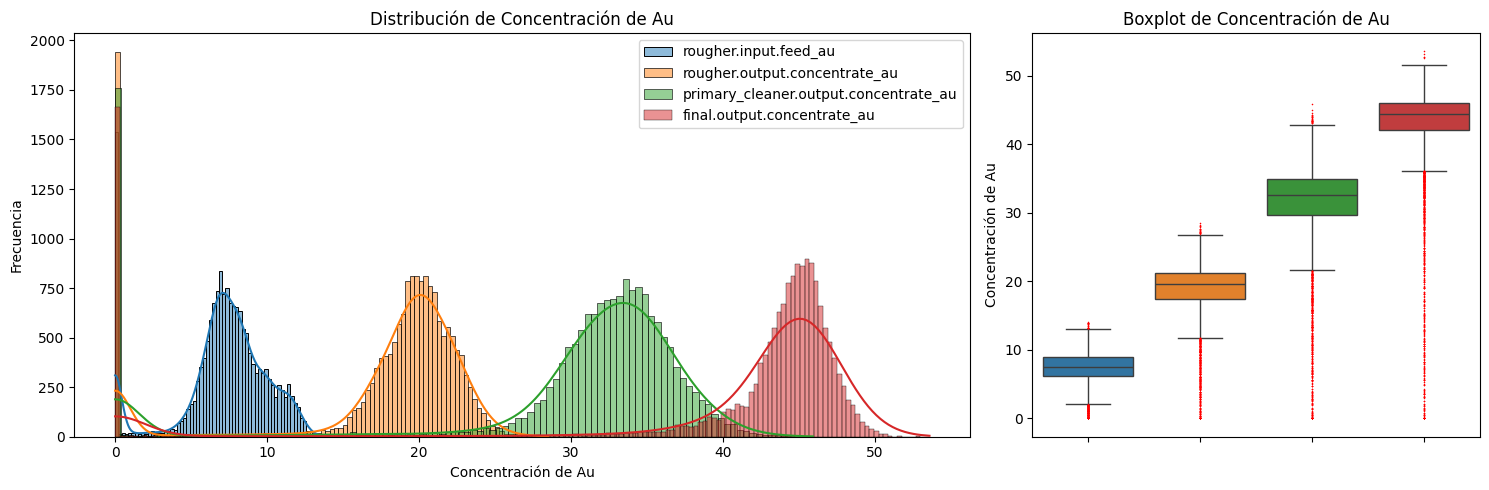

In [30]:
graficar_concentraciones(gold_recovery_full, elements['gold'])

It can be seen that the concentration of gold increases with each subsequent step. The boxplots also show that there are outliers at each stage.

**Silver concentration:**

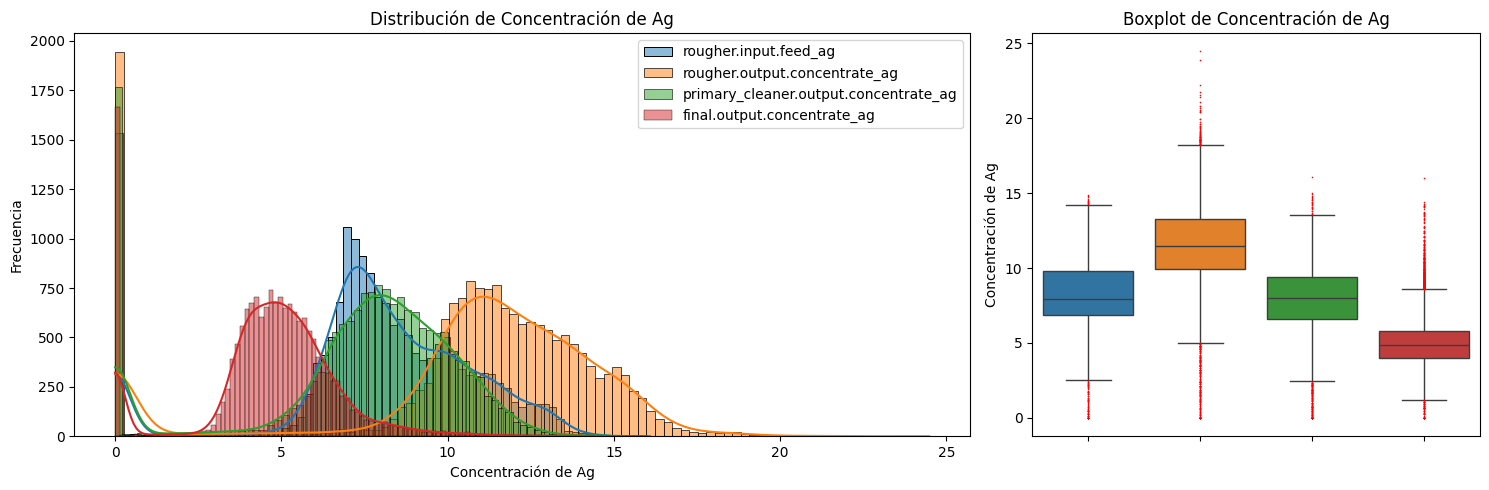

In [31]:
graficar_concentraciones(gold_recovery_full, elements['silver'])

We can see that the distribution shrinks and the concentration decreases with each stage.
There are also outliers here.

**Concentration of Lead:**

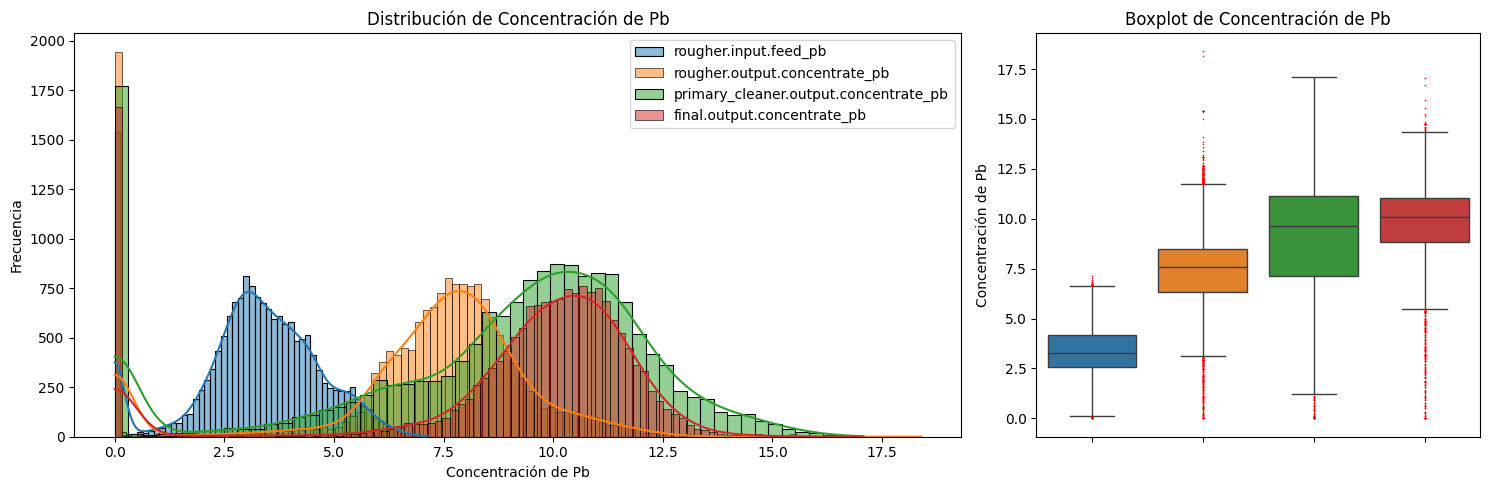

In [32]:
graficar_concentraciones(gold_recovery_full, elements['lead'])

According to the graphs above, the concentration of lead gradually increases during the first three stages of purification. Least of all lead at the start of the process, when it is mixed with gold-bearing ore. Surprisingly, the median indicator almost coincides at the last two stages, but the spread of values decreases at the final stage.

There are also outliers.

### Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

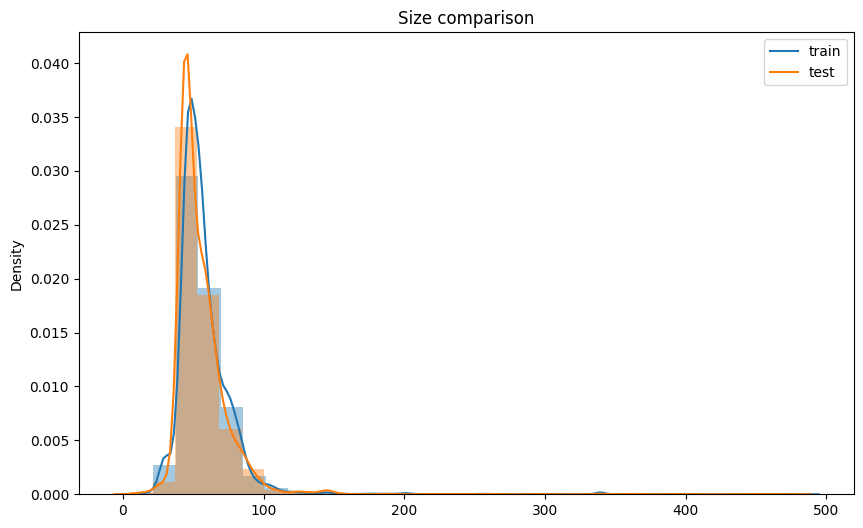

In [33]:
rougher_train_concentration = gold_recovery_train[gold_recovery_train['rougher.input.feed_size'] > 1]
rougher_test_concentration = gold_recovery_test[gold_recovery_test['rougher.input.feed_size'] > 1]

plt.figure(figsize=(10, 6))
sns.distplot(rougher_train_concentration[['rougher.input.feed_size']], bins=30)
sns.distplot(rougher_test_concentration[['rougher.input.feed_size']], bins=30)
plt.legend(['train', 'test'])
plt.title('Size comparison')
plt.show()

In general, the distributions are slightly different, but not critical. It can be seen that the test sample is dominated by larger granules.


### Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

In [34]:
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'

In [35]:
gold_recovery_full['raw_material'] = gold_recovery_full[[first+'au', first+'ag', first+'pb']].sum(axis=1)
gold_recovery_full['draft_concentrate'] = gold_recovery_full[[second+'au', second+'ag', second+'pb']].sum(axis=1)
gold_recovery_full['concentrate_after_filtering'] = gold_recovery_full[[third+'au', third+'ag', third+'pb']].sum(axis=1)
gold_recovery_full['final_concentrate'] = gold_recovery_full[[fourth+'au', fourth+'ag', fourth+'pb']].sum(axis=1)

In [36]:
gold_recovery_full[['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']].describe()

,raw_material,draft_concentrate,concentrate_after_filtering,final_concentrate
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,18.105071,34.692782,44.846544,53.072419
std,7.445510,13.747737,16.824879,18.727732
min,0.000000,0.000000,0.000000,0.000000
25%,16.082708,36.599327,48.192164,58.520159
50%,18.709881,39.451745,51.236693,59.983773
75%,22.327806,41.625835,53.173854,60.934461
max,35.071987,55.568687,60.269003,65.575259


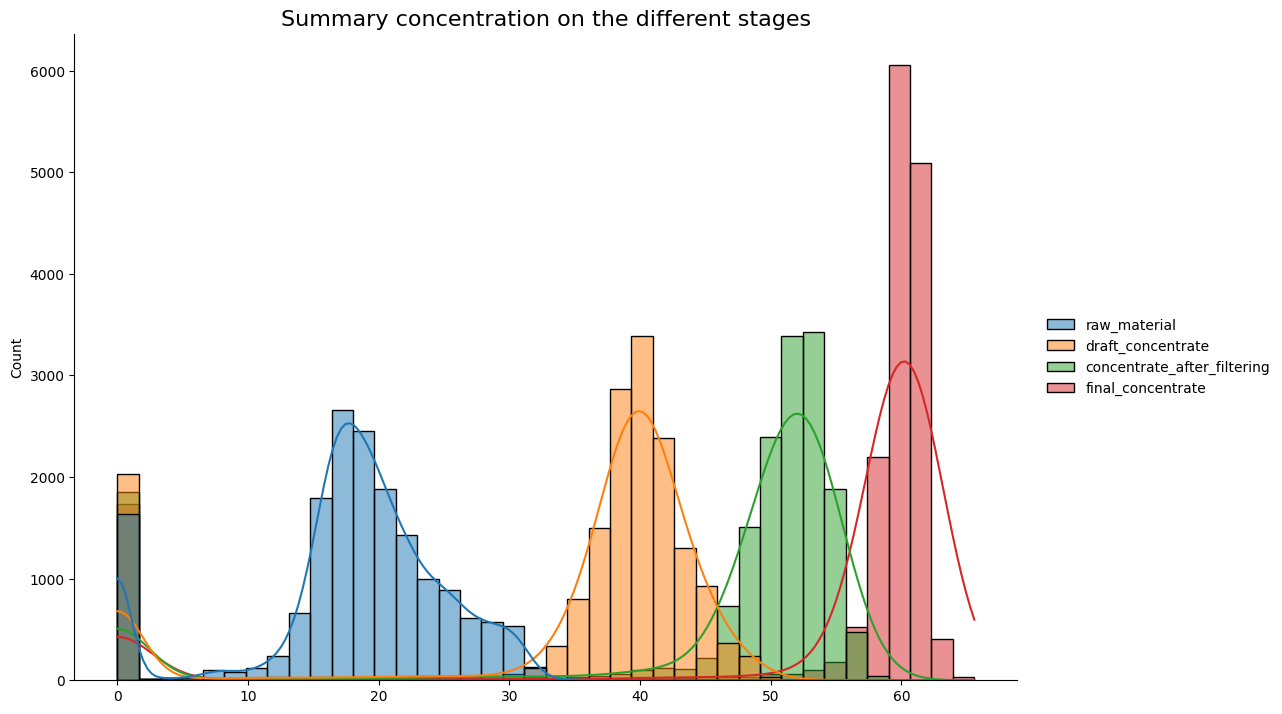

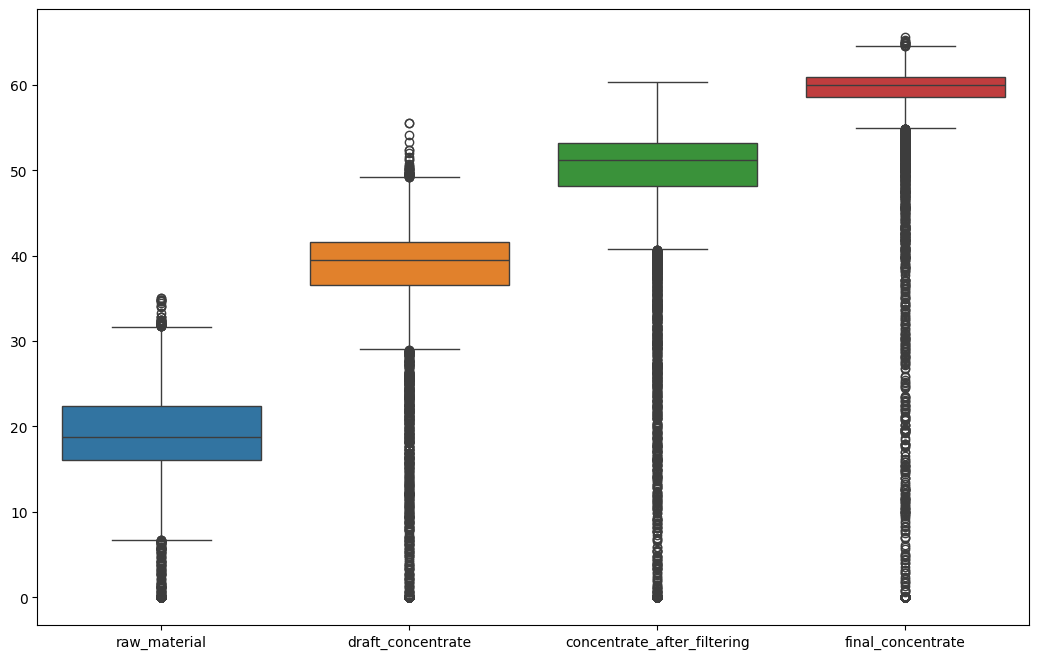

In [37]:
cols_all = ['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']

concentrate = gold_recovery_full[cols_all]

sns.displot(gold_recovery_full[cols_all],
            legend=True,
            kde=True,
            height=7,
            aspect=1.5)

plt.title('Summary concentration on the different stages', fontsize=16)

plt.figure(figsize=(12.8,8))
plt.xticks(rotation=0)
sns.boxplot(data=gold_recovery_full[cols_all])
plt.show()

There are a few 0 value outliers. In the raw, it can be connected with nonmetal materials. They may, however, have an impact on the performance of our models, so it is best to remove them.

In [38]:
for col in cols_all:
    print(col, 'zeros:', len(gold_recovery_full[gold_recovery_full[col] == 0]))
    print(col, 'under 1:', len(gold_recovery_full[gold_recovery_full[col] < 1]))
    print('\n')

raw_material zeros: 1241
raw_material under 1: 1619


draft_concentrate zeros: 1575
draft_concentrate under 1: 2027


concentrate_after_filtering zeros: 1312
concentrate_after_filtering under 1: 1847


final_concentrate zeros: 1334
final_concentrate under 1: 1736




In [39]:
full_clean = gold_recovery_full[
    (gold_recovery_full['raw_material'] >  1) &
    (gold_recovery_full['draft_concentrate'] > 1) &
    (gold_recovery_full['concentrate_after_filtering'] > 1) &
    (gold_recovery_full['final_concentrate'] > 1)
]

full_clean.shape

(14335, 91)

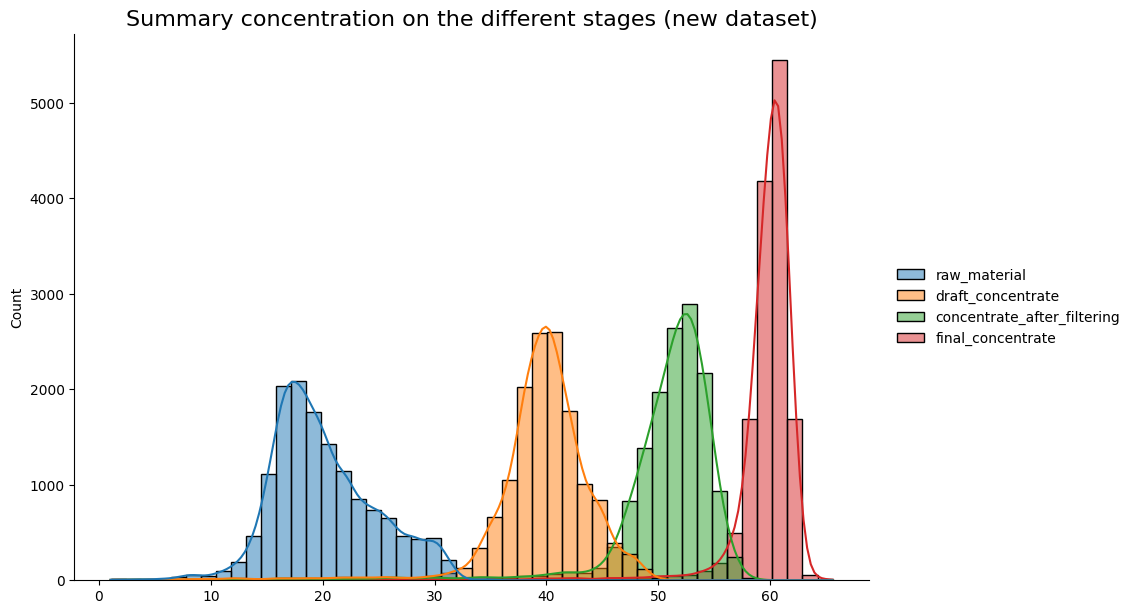

In [40]:
sns.displot(full_clean[['raw_material', 'draft_concentrate',
                       'concentrate_after_filtering', 'final_concentrate']],
            legend=True,
            kde=True,
            height=6,
            aspect=1.5)
plt.title('Summary concentration on the different stages (new dataset)', fontsize=16)
plt.show()

In [41]:
full_clean[['raw_material', 'draft_concentrate', 'concentrate_after_filtering', 'final_concentrate']].describe()

,raw_material,draft_concentrate,concentrate_after_filtering,final_concentrate
count,14335.000000,14335.000000,14335.000000,14335.000000
mean,20.095976,39.568605,50.587185,59.331386
std,4.650505,4.894529,5.678145,4.809330
min,1.130990,1.137053,1.037408,1.685441
25%,16.862334,38.028931,49.540930,59.128984
50%,19.250966,39.960824,51.713297,60.204717
75%,22.901401,41.944553,53.369035,61.021578
max,35.071987,55.568687,59.251060,65.575259


Train set:

In [42]:
train_clean = gold_recovery_train[gold_recovery_train['date'].isin(full_clean['date'])]
train_clean.dropna(inplace=True)
print('Train set', train_clean.shape)

Train set (14335, 55)


Test set:

In [43]:
full_clean['date'].value_counts()

,count
date,
2016-04-23 10:00:00,2
2017-08-13 09:00:00,1
2017-08-13 10:00:00,1
2017-08-13 11:00:00,1
2017-08-13 12:00:00,1
...,...
2016-08-26 23:00:00,1
2016-08-27 00:00:00,1
2016-08-27 01:00:00,1


In [44]:
gold_recovery_test['date'].value_counts()

,count
date,
2017-12-31 07:00:00,1
2017-12-31 06:00:00,1
2017-12-31 05:00:00,1
2017-12-31 04:00:00,1
2017-12-31 03:00:00,1
...,...
2016-09-01 04:00:00,1
2016-09-01 03:00:00,1
2016-09-01 02:00:00,1


In [45]:
test_clean = gold_recovery_test[gold_recovery_test['date'].isin(full_clean['date'])]
# test_clean.dropna(inplace=True)
print('Test set', test_clean.shape)

Test set (0, 55)


##  Build the model

### Write a function to calculate the final sMAPE value.

sMAPE = 25% sMAPE(rougher) + 75% sMAPE(final)

In [46]:
def total_smape(smape_rougher, smape_final):
    final_result = 0.25 * smape_rougher + 0.75 * smape_final
    return final_result

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

Cross validation will be used for models. Target features must be added to the training and test samples. "rougher.output.recovery" and "final.output.recovery" are the columns in question. Let us make our own training and testing samples, as well as targets for each target feature.

In [47]:
# train set:
target_rougher_train = train_clean['rougher.output.recovery']
target_final_train = train_clean['final.output.recovery']
features_train = train_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

#test set:
target_rougher_test = test_clean['rougher.output.recovery']
target_final_test = test_clean['final.output.recovery']
features_test = test_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [48]:
print('features_train', features_train.shape)
print('features_test', features_test.shape)

features_train (14335, 52)
features_test (0, 52)


In [49]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

ValueError: Found array with 0 sample(s) (shape=(0, 52)) while a minimum of 1 is required by StandardScaler.

In [ ]:
features_train.head()

In [ ]:
random_state = 123
cv = 5

In [ ]:
models = [DecisionTreeRegressor(random_state = random_state),
          RandomForestRegressor(random_state=random_state),
          LinearRegression()]

In [ ]:
#creating a function for sMAPE score:
def smape_scorer(target, predictions):
    smape = ((1 / len(target)) * (abs(target - predictions) / ((abs(target) + abs(predictions)) / 2))).sum() * 100
    return smape

In [ ]:
#creating a function for scoring the model:
def fit_and_check(model, params, gold_recovery_train, df_target):
    my_scorer = make_scorer(smape_scorer, greater_is_better=False)
    clf = GridSearchCV(model, params, scoring=my_scorer, cv=5)
    clf.fit(gold_recovery_train, df_target)

    return clf.best_estimator_, clf.best_score_

Let's check linear regression, decision tree and random forest models.

In [ ]:
results_cross_val = []

for model in models: */

    scorer = make_scorer(smape_scorer, greater_is_better=False)

    cross_val_score_rougher = cross_val_score(model,
                                              features_train,
                                              target_rougher_train,
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model,
                                            features_train,
                                            target_final_train,
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__,
                              'cross_val_score_rougher': cross_val_score_rougher,
                              'cross_val_score_final': cross_val_score_final})

pd.DataFrame(results_cross_val)

The best result is shown by the random forest model. We select hyperparameters and try to improve the performance of the model.

In [ ]:
%%time
results = []

for depth in range(1,5):

    for estimator in range(10, 21, 5):

        model = RandomForestRegressor(random_state=random_state,
                                       n_estimators=estimator,
                                       max_depth=depth)

        scorer = make_scorer(smape_scorer, greater_is_better=False)

        cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=cv, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=cv, scoring=scorer).mean()

        smape_final_result = total_smape(cross_val_score_rougher, cross_val_score_final)

        results.append({'model name': model.__class__.__name__,
                        'Hyperparameters': {'random_state': random_state,
                                            'n_estimators': estimator,
                                            'max_depth':depth},
                        'smape_final_result': smape_final_result})

pd.DataFrame(results).style.highlight_max(color = 'lightgreen', axis = 0)

As we see the best scoring has a Random Forest model. After checking it with hyperarameters I found out that the best result showed model with n_estimators - 15 and max_depth - 4

**The best models training**

In [ ]:
model_final = RandomForestRegressor(random_state=random_state,
                                       n_estimators=15,
                                       max_depth=4)

model_final.fit(features_train, target_rougher_train)
predictions_r = model_final.predict(features_test)

model_final.fit(features_train, target_final_train)
predictions_f = model_final.predict(features_test)

In [ ]:
smape_r = smape_scorer(target_rougher_test, predictions_r)
smape_f = smape_scorer(target_final_test, predictions_f)

print('Final sMAPE:', total_smape(smape_r, smape_f))

In [ ]:
len(gold_recovery_train) + len(gold_recovery_test)

In [ ]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_rougher_train)
predictions_r_dummy = dummy_regr.predict(features_test)

dummy_regr.fit(features_train, target_final_train)
predictions_f_dummy = dummy_regr.predict(features_test)

In [ ]:
smape_r_dummy = smape_scorer(target_rougher_test, predictions_r_dummy)
smape_f_dummy = smape_scorer(target_final_test, predictions_f_dummy)

print('Final sMAPE', total_smape(smape_r_dummy, smape_f_dummy))

The random forest model showed the best results.Sanity check also was successful.

# Conclusion


The project's goal of creating a prototype of a machine learning model that can predict the recovery rate of gold from gold ore has been met.
The data was processed and analyzed during the project, and a random forest model was built and trained as a result. The final model outperforms the constant model: the trained model's error is 7.7%, while the constant model's error is 7.9%.
During the project, the following steps were taken:

1. read and analyzed the data (prepared an EDA report for each dataset)
2. data that has been pre-processed (processing missing values, replacing data type, checking for duplicates)
3. double-checked the enrichment efficiency calculation.
4. investigated how metal concentrations (Au, Ag, Pb) change during the purification process. We can conclude that the concentration of each metal varies depending on the stage of purification: gold concentration gradually increases with each stage, silver concentration decreases, and lead concentration increases in the first three stages.
5. performed a granule size analysis on the training and test sets to ensure that the granule sizes are roughly evenly distributed in the training and test sets.
6. examined the total concentration of all metals at various stages, identifying and removing anomalies (a large number of zeros) from all datasets.
7. created functions to compute sMAPE and final sMAPE
8. compared the performance of various models (DecisionTreeRegressor (), RandomForestRegressor, LinearRegression) and how the best random forest model was selected using the hyperparameters n estimators = 15 and max depth = 4. The final model's work was tested on a test sample, and it performed well: the trained model's error is 7.7%, while the constant error is 7.9%.